### Example 8: Computing covariance matrices

This sample script showcases the ability of NaMaster to estimate the Gaussian covariance matrix for the pseudo-Cl estimator.

Field
Workspace
Covariance
Sample covariance
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


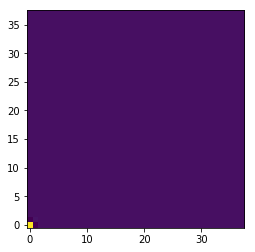

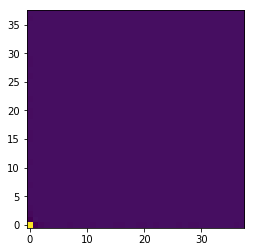

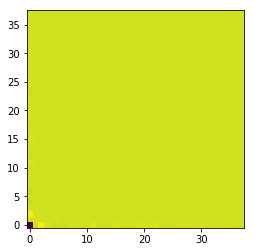

In [2]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pymaster as nmt

# This script showcases the ability of namaster to compute Gaussian
# estimates of the covariance matrix.
# A similar example for flat-sky fields can be found in
# test/sample_covariance_flat.py

# HEALPix map resolution
nside = 256

# We start by creating some synthetic masks and maps with contaminants.
# Here we will focus on the auto-correlation of a spin-1 field.
# a) Read and apodize mask
mask = nmt.mask_apodization(hp.read_map("mask.fits", verbose=False),
                            1., apotype="Smooth")

# Let's now create a fictitious theoretical power spectrum to generate
# Gaussian realizations:
larr = np.arange(3*nside)
clarr = ((larr+1.)/80.)**(-1.1)+1.
cl_tt = clarr
cl_ee = clarr
cl_bb = 0*clarr
cl_te = 0*clarr
cl_tb = 0*clarr
cl_eb = 0*clarr


# This routine generates a spin-0 and a spin-2 Gaussian random field based
# on these power spectra
def get_sample_field():
    mp_t, mp_q, mp_u = hp.synfast([cl_tt, cl_ee, cl_bb, cl_te],
                                  nside, verbose=False)
    return nmt.NmtField(mask, [mp_t]), nmt.NmtField(mask, [mp_q, mp_u])


# We also copy this function from sample_workspaces.py. It computes
# power spectra given a pair of fields and a workspace.
def compute_master(f_a, f_b, wsp):
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    cl_decoupled = wsp.decouple_cell(cl_coupled)

    return cl_decoupled


# Let's generate one particular sample and its power spectrum.
print("Field")
f0, f2 = get_sample_field()
# We will use 20 multipoles per bandpower.
##b = nmt.NmtBin.from_nside_linear(nside, 20)
b= nmt.NmtBin(nside,nlb=20)


print("Workspace")
w00 = nmt.NmtWorkspace()
w00.compute_coupling_matrix(f0, f0, b)
w02 = nmt.NmtWorkspace()
w02.compute_coupling_matrix(f0, f2, b)
w22 = nmt.NmtWorkspace()
w22.compute_coupling_matrix(f2, f2, b)
cl_00 = compute_master(f0, f0, w00)
cl_02 = compute_master(f0, f2, w02)
cl_22 = compute_master(f2, f2, w22)
n_ell = len(cl_00[0])

# Let's now compute the Gaussian estimate of the covariance!
print("Covariance")
# First we generate a NmtCovarianceWorkspace object to precompute
# and store the necessary coupling coefficients
cw = nmt.NmtCovarianceWorkspace()
# This is the time-consuming operation
# Note that you only need to do this once,
# regardless of spin
cw.compute_coupling_coefficients(f0, f0, f0, f0)

# The next few lines show how to extract the covariance matrices
# for different spin combinations.
covar_00_00 = nmt.gaussian_covariance(cw,
                                      0, 0, 0, 0,  # Spins of the 4 fields
                                      [cl_tt],  # TT
                                      [cl_tt],  # TT
                                      [cl_tt],  # TT
                                      [cl_tt],  # TT
                                      w00, wb=w00).reshape([n_ell, 1,
                                                            n_ell, 1])
covar_TT_TT = covar_00_00[:, 0, :, 0]
covar_02_02 = nmt.gaussian_covariance(cw, 0, 2, 0, 2,  # Spins of the 4 fields
                                      [cl_tt],  # TT
                                      [cl_te, cl_tb],  # TE, TB
                                      [cl_te, cl_tb],  # ET, BT
                                      [cl_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      w02, wb=w02).reshape([n_ell, 2,
                                                            n_ell, 2])
covar_TE_TE = covar_02_02[:, 0, :, 0]
covar_TE_TB = covar_02_02[:, 0, :, 1]
covar_TB_TE = covar_02_02[:, 1, :, 0]
covar_TB_TB = covar_02_02[:, 1, :, 1]


covar_00_22 = nmt.gaussian_covariance(cw, 0, 0, 2, 2,  # Spins of the 4 fields
                                      [cl_te, cl_tb],  # TE, TB
                                      [cl_te, cl_tb],  # TE, TB
                                      [cl_te, cl_tb],  # TE, TB
                                      [cl_te, cl_tb],  # TE, TB
                                      w00, wb=w22).reshape([n_ell, 1,
                                                            n_ell, 4])
covar_TT_EE = covar_00_22[:, 0, :, 0]
covar_TT_EB = covar_00_22[:, 0, :, 1]
covar_TT_BE = covar_00_22[:, 0, :, 2]
covar_TT_BB = covar_00_22[:, 0, :, 3]

covar_02_22 = nmt.gaussian_covariance(cw, 0, 2, 2, 2,  # Spins of the 4 fields
                                      [cl_te, cl_tb],  # TE, TB
                                      [cl_te, cl_tb],  # TE, TB
                                      [cl_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      [cl_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      w02, wb=w22).reshape([n_ell, 2,
                                                            n_ell, 4])
covar_TE_EE = covar_02_22[:, 0, :, 0]
covar_TE_EB = covar_02_22[:, 0, :, 1]
covar_TE_BE = covar_02_22[:, 0, :, 2]
covar_TE_BB = covar_02_22[:, 0, :, 3]
covar_TB_EE = covar_02_22[:, 1, :, 0]
covar_TB_EB = covar_02_22[:, 1, :, 1]
covar_TB_BE = covar_02_22[:, 1, :, 2]
covar_TB_BB = covar_02_22[:, 1, :, 3]


covar_22_22 = nmt.gaussian_covariance(cw, 2, 2, 2, 2,  # Spins of the 4 fields
                                      [cl_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      [cl_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      [cl_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      [cl_ee, cl_eb,
                                       cl_eb, cl_bb],  # EE, EB, BE, BB
                                      w22, wb=w22).reshape([n_ell, 4,
                                                            n_ell, 4])
covar_EE_EE = covar_22_22[:, 0, :, 0]
covar_EE_EB = covar_22_22[:, 0, :, 1]
covar_EE_BE = covar_22_22[:, 0, :, 2]
covar_EE_BB = covar_22_22[:, 0, :, 3]
covar_EB_EE = covar_22_22[:, 1, :, 0]
covar_EB_EB = covar_22_22[:, 1, :, 1]
covar_EB_BE = covar_22_22[:, 1, :, 2]
covar_EB_BB = covar_22_22[:, 1, :, 3]
covar_BE_EE = covar_22_22[:, 2, :, 0]
covar_BE_EB = covar_22_22[:, 2, :, 1]
covar_BE_BE = covar_22_22[:, 2, :, 2]
covar_BE_BB = covar_22_22[:, 2, :, 3]
covar_BB_EE = covar_22_22[:, 3, :, 0]
covar_BB_EB = covar_22_22[:, 3, :, 1]
covar_BB_BE = covar_22_22[:, 3, :, 2]
covar_BB_BB = covar_22_22[:, 3, :, 3]

# Let's now compute the sample covariance
# (we'll only do this for spin-0 for simplicity
print("Sample covariance")
nsamp = 100
covar_sample = np.zeros([n_ell, n_ell])
mean_sample = np.zeros(n_ell)
for i in np.arange(nsamp):
    print(i)
    f, _ = get_sample_field()
    cl = compute_master(f, f, w00)[0]
    covar_sample += cl[None, :]*cl[:, None]
    mean_sample += cl
mean_sample /= nsamp
covar_sample = covar_sample / nsamp
covar_sample -= mean_sample[None, :] * mean_sample[:, None]

# Let's plot them:
plt.figure()
plt.imshow(covar_TT_TT, origin='lower', interpolation='nearest')
plt.figure()
plt.imshow(covar_sample, origin='lower', interpolation='nearest')
plt.figure()
plt.imshow(covar_TT_TT-covar_sample, origin='lower', interpolation='nearest')
plt.show();